# Machine Learning_Final Model

## Import Libraries

In [29]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import color maps
import matplotlib.cm as cm
import string
# import model related libraries
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, _forest
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import roc_auc_score, fbeta_score, classification_report, confusion_matrix, recall_score, accuracy_score, balanced_accuracy_score
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# import a function that convert items into a callable object
from operator import itemgetter
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

pd.options.display.max_colwidth = 200
%matplotlib inline
%run functions.ipynb # import my functions from functions notebook

Stored 'my_stop_words' (list)
sucessfully ran function nobtebook!


## Load Data

In [2]:
# load master dataframe with features ready to be transformed and used by the model
master = pd.read_csv('../data/master.csv')
master.drop('Unnamed: 0',axis=1,inplace=True)
master.columns

Index(['SUBJECT_ID', 'HADM_ID', 'READMISSION_30DAYS', 'DISCHARGE_LOCATION',
       'INSURANCE', 'MARITAL_STATUS', 'GENDER', 'AGE', 'ETHNICITY_GRP',
       'CURR_SERVICE', 'NUM_PRESCRIPTION', 'LOS', 'HLOS_CL', 'LOS_RATIO', 'KD',
       'HP', 'PUL', 'UT', 'HIV', 'DB', 'MBD', 'TB', 'GA', 'HM', 'HEP', 'HO',
       'FR', 'TX', 'LA', 'AF', 'CB', 'PNE', 'HF', 'SP', 'WMCC', 'WCC',
       'WOCCMCC', 'WOMCC', 'WCCMCC', 'DRG_SEVERITY', 'DRG_MORTALITY', 'TEXT',
       'TEXT_CL', 'AGE_boxcox_lambda_opt', 'NUM_PRESCRIPTION_LOG', 'LOS_LOG',
       'LOS_boxcox_lambda_opt', 'HLOS_CL_LOG', 'HLOS_CL_boxcox_lambda_opt',
       'LOS_RATIO_LOG', 'LOS_RATIO_boxcox_lambda_opt'],
      dtype='object')

## Transform features using pipeline

As a preparation for building and evaluating the final model, all features need to be transformed and combined into a single dataframe

In [13]:
# using datapipeline tools DataFrameMapper to map each feature to the appropriate format before using it in the model
mapper = DataFrameMapper([
    ('TEXT', TfidfVectorizer(min_df=10, max_features=3000, lowercase=True, #ngram_range=(2, 2),
                             tokenizer=tokenizer_better, stop_words=my_stop_words, use_idf=True))
    ,('DISCHARGE_LOCATION', LabelEncoder())
    ,('INSURANCE',          LabelEncoder())
    ,('MARITAL_STATUS',     LabelEncoder())
    ,('ETHNICITY_GRP',      LabelEncoder())
    ,('CURR_SERVICE',       LabelEncoder())
    ,('GENDER',             LabelEncoder())
    ,('AGE_boxcox_lambda_opt',        None)
#    ,(['AGE'], KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile'))
    ,('NUM_PRESCRIPTION_LOG', None)
#    ,('LOS_LOG',                None)
#    ,('LOS_boxcox_lambda_opt', None)
#    ,('HLOS_CL_LOG',               None)
#    ,('HLOS_CL_boxcox_lambda_opt', None)
#    ,(['LOS_RATIO'], KBinsDiscretizer(n_bins=5, encode='onehot', strategy='quantile'))
#    ,('LOS_RATIO_LOG', None)
    ,('LOS_RATIO_boxcox_lambda_opt', None)
    ,('KD',                 None)
    ,('HP',                 None)
    ,('PUL',                None)
    ,('UT',                 None)
    ,('HIV',                None)
    ,('DB',                 None)
    ,('MBD',                None)
    ,('TB',                 None)
    ,('GA',                 None)
    ,('HM',                 None)
    ,('HF',                 None)
    ,('HEP',                None)
    ,('HO',                 None)
    ,('FR',                 None)
    ,('TX',                 None)
    ,('LA',                 None)
    ,('AF',                 None)
    ,('CB',                 None)
    ,('SP',                 None)
    ,('PNE',                None)
    ,('WMCC',               None)
    ,('WCC',                None)
    ,('WOCCMCC',            None)
    ,('WOMCC',              None)
    ,('WCCMCC',             None)
#    ,('DRG_SEVERITY',       None)
#    ,('DRG_MORTALITY',      None)
], df_out=True)

In [14]:
# fit and transform the master dataset including discharge notes to return a final feature set
set_all = mapper.fit_transform(master)

In [15]:
set_all.shape

(8308, 3034)

In [16]:
set_all.columns[-40:]

Index(['TEXT_yourself', 'TEXT_yrs', 'TEXT_zinc', 'TEXT_zofran',
       'TEXT_zolpidem', 'TEXT_zosyn', 'DISCHARGE_LOCATION', 'INSURANCE',
       'MARITAL_STATUS', 'ETHNICITY_GRP', 'CURR_SERVICE', 'GENDER',
       'AGE_boxcox_lambda_opt', 'NUM_PRESCRIPTION_LOG',
       'LOS_RATIO_boxcox_lambda_opt', 'KD', 'HP', 'PUL', 'UT', 'HIV', 'DB',
       'MBD', 'TB', 'GA', 'HM', 'HF', 'HEP', 'HO', 'FR', 'TX', 'LA', 'AF',
       'CB', 'SP', 'PNE', 'WMCC', 'WCC', 'WOCCMCC', 'WOMCC', 'WCCMCC'],
      dtype='object')

In [27]:
X_train_all, X_valid_all, y_train, y_valid = train_test_split(set_all, master.READMISSION_30DAYS, test_size=0.3)
print('training size: ', X_train_all.shape[0])
print('test size: ', X_valid_all.shape[0])

training size:  5815
test size:  2493


### Baseline model

In [105]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train_s3, y_train)
print('Dummy Model performance score: ', round(dummy_clf.score(X_train_all, y_train),4))

Dummy Model performance score:  0.6057


## Find the best C-value with L1 penalty with Logistic Regression

In [106]:
params = {'C': np.linspace(start = 0, stop = 2, num = 10)}

logistic = LogisticRegression(penalty='l1',solver='liblinear')

clf = GridSearchCV(logistic, param_grid=params,  scoring = "roc_auc", cv = 3, verbose =1, n_jobs = -1)

In [107]:
best_model = clf.fit(X_train_all, y_train)
print('Best C:', best_model.best_estimator_.get_params()['C'])
#cv_scores = best_model.cv_results_[best_model.cv_results_['mean_test_score']!='nan']
#print('Best avg. AUC :', np.mean(cv_scores))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   47.8s finished


Best C: 2.0


In [113]:
best_estimator.score()

NameError: name 'best_estimator' is not defined

## Create subsets of features using different C-values

In [108]:
X_train_s1, X_valid_s1 = create_feature_subset(c=0.67, X_train=X_train_all, X_valid=X_valid_all, y_train=y_train)
X_train_s2, X_valid_s2 = create_feature_subset(c=1.0, X_train=X_train_all, X_valid=X_valid_all, y_train=y_train)
X_train_s3, X_valid_s3 = create_feature_subset(c=2.0, X_train=X_train_all, X_valid=X_valid_all, y_train=y_train)

LogisticRegression-L1 picked 98 variables and eliminated the other 2936 variables
TEXT_subdural      3.736139
TEXT_metastatic    3.644777
TEXT_campus        3.418166
TEXT_trach         1.909928
TEXT_peg           1.869254
dtype: float64
LogisticRegression-L1 picked 188 variables and eliminated the other 2846 variables
TEXT_metastatic      4.329391
TEXT_subdural        4.050962
TEXT_transitional    3.893378
TEXT_campus          3.271736
TEXT_powder          2.826518
dtype: float64
LogisticRegression-L1 picked 570 variables and eliminated the other 2464 variables
TEXT_transitional    7.977199
TEXT_lifting         6.536317
TEXT_powder          6.224130
TEXT_simple          5.541610
TEXT_recommend       5.180892
dtype: float64


## Find best parameters for several classifiers with 3 subset of features

To further improve model performance, I will tune the parameters of a few tree-base algorithm and linearSVC model with 3 subsets of important features found using logistic regression with L1 penalty with 3 different C-values

In [109]:
print(X_train_s1.shape, X_valid_s1.shape)
print(X_train_s2.shape, X_valid_s2.shape)
print(X_train_s3.shape, X_valid_s3.shape)

(5815, 98) (2493, 98)
(5815, 188) (2493, 188)
(5815, 570) (2493, 570)


In [110]:
models = {
    'LogisticRegression' : LogisticRegression(penalty = 'l2', random_state = 0)
    ,'RandomForestClassifier': RandomForestClassifier()
    ,'AdaBoostClassifier': AdaBoostClassifier()
    ,'GradientBoostingClassifier': GradientBoostingClassifier()
    ,'XGBClassifier': XGBClassifier()
#    'SVC': SVC()
}

params1 = {
    'LogisticRegression' : {'C': np.linspace(start = 0, stop = 2, num = 10), 'solver': ['liblinear','lbfgs'] },
    'RandomForestClassifier': { 'n_estimators': [50, 99],'max_depth' : [1, 5],'min_samples_split' : [5, 10] },
    'AdaBoostClassifier':  { 'n_estimators': [50, 99],'learning_rate': [0.3, 1.0] },
    'GradientBoostingClassifier': { 'n_estimators': [75, 99], 'learning_rate': [0.8, 1] },
    'XGBClassifier': { 'n_estimators': [50, 99],'learning_rate': [0.05, 0.3, 1.0], 'max_depth': [1, 3], 
                      'min_child_weight' : [2, 10] }
#    'SVC': {'kernel': ['linear'], 'C': [1, 10]},
}

params2 = {
    'LogisticRegression' : {'C': np.linspace(start = 0, stop = 2, num = 10), 'solver': ['liblinear','lbfgs'] },
    'RandomForestClassifier': { 'n_estimators': [100, 189],'max_depth' : [1, 5],'min_samples_split' : [5, 10] },
    'AdaBoostClassifier':  { 'n_estimators': [100, 189],'learning_rate': [0.3, 1.0] },
    'GradientBoostingClassifier': { 'n_estimators': [100, 189], 'learning_rate': [0.8, 1.0]},
    'XGBClassifier': { 'n_estimators': [100, 189],'learning_rate': [0.05, 0.3, 1.0], 'max_depth': [1, 3], 
                      'min_child_weight' : [2, 10]}
}
params3 = {
    'LogisticRegression' : {'C': np.linspace(start = 0, stop = 2, num = 10), 'solver': ['liblinear','lbfgs'] },
    'RandomForestClassifier': { 'n_estimators': [285, 570],'max_depth' : [1, 3],'min_samples_split' : [5, 10] },
    'AdaBoostClassifier':  { 'n_estimators': [285, 570],'learning_rate': [0.3, 1.0] },
    'GradientBoostingClassifier': { 'n_estimators': [285, 570], 'learning_rate': [0.8, 1.0]},
    'XGBClassifier': { 'n_estimators': [285, 570],'learning_rate': [0.05, 0.3, 1.0], 'max_depth': [1, 3], 
                      'min_child_weight' : [2, 10]}
}

In [127]:
helper1 = EstimatorSelectionHelper(models, params1)
helper1.fit(X_train_s1, y_train, scoring='roc_auc', n_jobs=2)

Running GridSearchCV for LogisticRegression.
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.8s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   10.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed:    6.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:   12.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:   32.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for XGBClassifier.
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   33.6s
[Parallel(n_jobs=2)]: Done  72 out of  72 | elapsed:   54.1s finished


In [128]:
helper1.score_summary(sort_by='mean_score')

LogisticRegression
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier


,estimator,min_score,mean_score,max_score,std_score,C,solver,max_depth,min_samples_split,n_estimators,learning_rate,min_child_weight
18,LogisticRegression,0.667032,0.669047,0.672535,0.00247682,2,liblinear,NaN,NaN,NaN,NaN,NaN
16,LogisticRegression,0.665473,0.667682,0.670727,0.00222512,1.77778,liblinear,NaN,NaN,NaN,NaN,NaN
14,LogisticRegression,0.663513,0.666146,0.669304,0.00239293,1.55556,liblinear,NaN,NaN,NaN,NaN,NaN
12,LogisticRegression,0.658282,0.663334,0.667534,0.0038251,1.33333,liblinear,NaN,NaN,NaN,NaN,NaN
10,LogisticRegression,0.655992,0.660797,0.664649,0.00359776,1.11111,liblinear,NaN,NaN,NaN,NaN,NaN
8,LogisticRegression,0.651291,0.65692,0.660427,0.00402059,0.888889,liblinear,NaN,NaN,NaN,NaN,NaN
47,XGBClassifier,0.64927,0.656768,0.66935,0.00895077,NaN,NaN,1,NaN,99,0.3,10
27,RandomForestClassifier,0.644177,0.655737,0.662613,0.00822273,NaN,NaN,5,10,99,NaN,NaN
26,RandomForestClassifier,0.651395,0.654055,0.6558,0.00191099,NaN,NaN,5,10,50,NaN,NaN
25,RandomForestClassifier,0.648287,0.653868,0.662227,0.0060206,NaN,NaN,5,5,99,NaN,NaN


In [57]:
helper2 = EstimatorSelectionHelper(models, params2)
helper2.fit(X_train_s2, y_train, scoring='roc_auc', n_jobs=2)

Running GridSearchCV for LogisticRegression.
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   16.8s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   19.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed:   15.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:   47.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:  1.9min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for XGBClassifier.
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done  72 out of  72 | elapsed:  3.5min finished


In [58]:
helper2.score_summary(sort_by='mean_score')

LogisticRegression
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier


,estimator,min_score,mean_score,max_score,std_score,C,solver,max_depth,min_samples_split,n_estimators,learning_rate,min_child_weight
18,LogisticRegression,0.687353,0.689899,0.691196,0.00180065,2,liblinear,NaN,NaN,NaN,NaN,NaN
16,LogisticRegression,0.685186,0.687652,0.689369,0.00178825,1.77778,liblinear,NaN,NaN,NaN,NaN,NaN
12,LogisticRegression,0.677458,0.682173,0.684571,0.00333399,1.33333,liblinear,NaN,NaN,NaN,NaN,NaN
14,LogisticRegression,0.681,0.682138,0.682964,0.00083171,1.55556,liblinear,NaN,NaN,NaN,NaN,NaN
10,LogisticRegression,0.671625,0.677947,0.681391,0.00447587,1.11111,liblinear,NaN,NaN,NaN,NaN,NaN
47,XGBClassifier,0.664519,0.675089,0.684178,0.00809385,NaN,NaN,1,NaN,189,0.3,10
29,AdaBoostClassifier,0.67004,0.672732,0.677954,0.00369354,NaN,NaN,NaN,NaN,189,0.3,NaN
8,LogisticRegression,0.665809,0.67242,0.676094,0.00468469,0.888889,liblinear,NaN,NaN,NaN,NaN,NaN
45,XGBClassifier,0.664013,0.670643,0.682841,0.0086359,NaN,NaN,1,NaN,189,0.3,2
48,XGBClassifier,0.654942,0.667337,0.676734,0.00914561,NaN,NaN,3,NaN,100,0.3,2


In [111]:
helper3 = EstimatorSelectionHelper(models, params3)
helper3.fit(X_train_s3, y_train, scoring='roc_auc', n_jobs=2)

Running GridSearchCV for LogisticRegression.
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  1.2min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:  8.6min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed: 16.1min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for XGBClassifier.
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 18.4min
[Parallel(n_jobs=2)]: Done  72 out of  72 | elapsed: 27.3min finished


In [112]:
helper3.score_summary(sort_by='mean_score')

LogisticRegression
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier


,estimator,min_score,mean_score,max_score,std_score,C,solver,max_depth,min_samples_split,n_estimators,learning_rate,min_child_weight
18,LogisticRegression,0.722747,0.723122,0.723377,0.000270691,2,liblinear,NaN,NaN,NaN,NaN,NaN
16,LogisticRegression,0.718373,0.719402,0.720527,0.000881818,1.77778,liblinear,NaN,NaN,NaN,NaN,NaN
14,LogisticRegression,0.713689,0.715365,0.716874,0.00130547,1.55556,liblinear,NaN,NaN,NaN,NaN,NaN
12,LogisticRegression,0.707009,0.710224,0.712618,0.00236234,1.33333,liblinear,NaN,NaN,NaN,NaN,NaN
10,LogisticRegression,0.699355,0.703822,0.706762,0.00321065,1.11111,liblinear,NaN,NaN,NaN,NaN,NaN
49,XGBClassifier,0.68656,0.696256,0.702549,0.00695679,NaN,NaN,3,NaN,570,0.3,2
8,LogisticRegression,0.688913,0.694712,0.697739,0.0041019,0.888889,liblinear,NaN,NaN,NaN,NaN,NaN
47,XGBClassifier,0.683633,0.689032,0.695435,0.00486993,NaN,NaN,1,NaN,570,0.3,10
45,XGBClassifier,0.68485,0.687435,0.690406,0.00228433,NaN,NaN,1,NaN,570,0.3,2
51,XGBClassifier,0.672369,0.686682,0.699825,0.0112392,NaN,NaN,3,NaN,570,0.3,10


Best model with a mean ROC_AUC score range of 72.24%-72.3% (95% confidence interval) is the Logistic Regression L2 with C = 2.0 and 570 features in set3. 

In [134]:
# logistic regression using subset3 of features, Test AUC score using full feature set is 65.44%
clf_lo = LogisticRegression(C=2.0, penalty='l2', solver='liblinear').fit(X_train_s3,y_train)

y_train_preds = clf_lo.predict_proba(X_train_s3)[:,1]
y_valid_preds = clf_lo.predict_proba(X_valid_s3)[:,1]

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print ("AUC on training data: ","{0:.3%}".format(auc_train))
print ("AUC on test data: ","{0:.3%}".format(auc_valid))

AUC on training data:  80.757%
AUC on test data:  65.580%


In [132]:
xgb = XGBClassifier(max_depth=3, n_estimators=570, learning_rate=0.3, min_child_weight=2).fit(X_train_s3,y_train)

y_train_preds = xgb.predict_proba(X_train_s3)[:,1]
y_valid_preds = xgb.predict_proba(X_valid_s3)[:,1]

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print ("AUC on training data: ","{0:.3%}".format(auc_train))
print ("AUC on test data: ","{0:.3%}".format(auc_valid))

AUC on training data:  99.978%
AUC on test data:  62.681%


In [133]:
gb = GradientBoostingClassifier(n_estimators=570, learning_rate=0.8).fit(X_train_s3,y_train)

y_train_preds = gb.predict_proba(X_train_s3)[:,1]
y_valid_preds = gb.predict_proba(X_valid_s3)[:,1]

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print ("AUC on training data: ","{0:.3%}".format(auc_train))
print ("AUC on test data: ","{0:.3%}".format(auc_valid))

AUC on training data:  100.000%
AUC on test data:  60.711%


In [135]:
ada = AdaBoostClassifier(n_estimators=570,learning_rate=0.3).fit(X_train_s3,y_train)

y_train_preds = ada.predict_proba(X_train_s3)[:,1]
y_valid_preds = ada.predict_proba(X_valid_s3)[:,1]

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print ("AUC on training data: ","{0:.3%}".format(auc_train))
print ("AUC on test data: ","{0:.3%}".format(auc_valid))

AUC on training data:  91.646%
AUC on test data:  62.886%


In [137]:
rf = RandomForestClassifier(n_estimators=285, max_depth=3, min_samples_split=10).fit(X_train_s3,y_train)

y_train_preds = rf.predict_proba(X_train_s3)[:,1]
y_valid_preds = rf.predict_proba(X_valid_s3)[:,1]

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print ("AUC on training data: ","{0:.3%}".format(auc_train))
print ("AUC on test data: ","{0:.3%}".format(auc_valid))

AUC on training data:  72.033%
AUC on test data:  65.366%


## Threshold Modeling

Find the threshold probability with the highest F score using LogisticRegression L2 C=2.0

In [85]:
print(y_true.shape,y_valid_class.shape)

(5815,) (5815,)


In [86]:
y_true = y_train.reset_index(drop=True)
y_valid_class = (y_train_preds >= 0.5).astype(int)
thresholds=np.arange(0,1,.01)

accuracy = accuracy_score(y_true, y_valid_class)
print('Accuracy score: ',accuracy)

baccuracy = balanced_accuracy_score(y_true, y_valid_class)
print('Balanced accuracy score: ',baccuracy)

beta, best_threshold, best_fscore, fscores_thres_pairs, adj_class, fscores = \
                    create_fbeta_score(y_true=y_true, y_valid_preds=y_train_preds, thresholds=thresholds, beta=1)
 
print ("Threshold probability with best F-score : ",  round(best_threshold,2), 
       round(best_fscore,2), "beta = ", beta)

Accuracy score:  0.7602751504729148
Balanced accuracy score:  0.5725344600728819
Threshold probability with best F-score :  0.25 0.54 beta =  1


In [103]:
beta_v1, best_threshold_v1, best_fscore_v1, fscores_thres_pairs_v1, adj_class_v1, fscores_v1= \
            create_fbeta_score(y_true=y_true, y_valid_preds=y_train_preds, thresholds=thresholds, beta=0.5)
beta_v2, best_threshold_v2, best_fscore_v2, fscores_thres_pairs_v2, adj_class_v2, fscores_v2 = \
            create_fbeta_score(y_true=y_true, y_valid_preds=y_train_preds, thresholds=thresholds, beta=1)
beta_v3, best_threshold_v3, best_fscore_v3, fscores_thres_pairs_v3, adj_class_v3, fscores_v3 = \
            create_fbeta_score(y_true=y_true, y_valid_preds=y_train_preds, thresholds=thresholds, beta=2)

In [104]:
print('beta = ',beta_v1, ' threshold = ',best_threshold_v1, ' best_fscore = ',best_fscore_v1)
print(classification_report(y_true, adj_class_v1))

tn_v1, fp_v1, fn_v1, tp_v1 = (confusion_matrix(y_true, adj_class_v1).ravel())
print('tn: ',tn_v1,'fp: ',fp_v1,'fn: ',fn_v1,'tp: ',tp_v1,'\n')
print('--------------------------------------------------------------------------------------')
print('beta = ',beta_v2, ' threshold = ',best_threshold_v2, ' best_fscore = ',best_fscore_v2)
print(classification_report(y_true, adj_class_v2))

tn_v2, fp_v2, fn_v2, tp_v2 = (confusion_matrix(y_true, adj_class_v2).ravel())
print('tn: ',tn_v2,'fp: ',fp_v2,'fn: ',fn_v2,'tp: ',tp_v2)
print('--------------------------------------------------------------------------------------')
print('beta = ',beta_v3, ' threshold = ',best_threshold_v3, ' best_fscore = ',best_fscore_v3)
print(classification_report(y_true, adj_class_v3))

tn_v3, fp_v3, fn_v3, tp_v3 = (confusion_matrix(y_true, adj_class_v3).ravel())
print('tn: ',tn_v3,'fp: ',fp_v3,'fn: ',fn_v3,'tp: ',tp_v3)

beta =  0.5  threshold =  0.38  best_fscore =  0.5516472203157173
              precision    recall  f1-score   support

         0.0       0.81      0.90      0.85      4251
         1.0       0.60      0.41      0.49      1564

    accuracy                           0.77      5815
   macro avg       0.70      0.66      0.67      5815
weighted avg       0.75      0.77      0.75      5815

tn:  3828 fp:  423 fn:  921 tp:  643 

--------------------------------------------------------------------------------------
beta =  1  threshold =  0.25  best_fscore =  0.540638442381707
              precision    recall  f1-score   support

         0.0       0.88      0.61      0.72      4251
         1.0       0.42      0.76      0.54      1564

    accuracy                           0.65      5815
   macro avg       0.65      0.69      0.63      5815
weighted avg       0.75      0.65      0.67      5815

tn:  2592 fp:  1659 fn:  370 tp:  1194
----------------------------------------------------

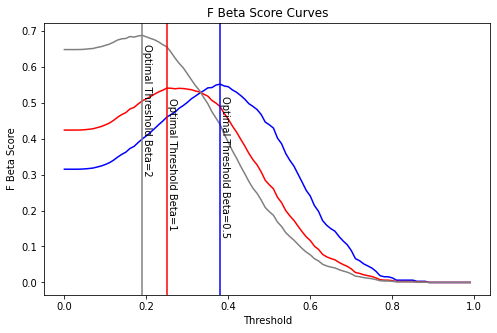

In [147]:
plt.figure(figsize=(8,5))
plt.plot(thresholds, fscores_v1, color='blue')
plt.plot(thresholds, fscores_v2, color='red')
plt.plot(thresholds, fscores_v3, color='grey')
plt.title('F Beta Score Curves')
#plt.legend(('F Beta 1', 'F Beta 2'))
plt.xlabel('Threshold')
plt.axvline(x=best_threshold_v1, color='blue')
plt.text(best_threshold_v1,0.13,'Optimal Threshold Beta=0.5', rotation=-90)
plt.axvline(x=best_threshold_v2, color='red')
plt.text(best_threshold_v2,0.15,'Optimal Threshold Beta=1', rotation=-90)
plt.axvline(x=best_threshold_v3, color='grey')
plt.text(best_threshold_v3,0.3,'Optimal Threshold Beta=2', rotation=-90)
plt.ylabel('F Beta Score')
plt.show()

In [ ]:
recall_score(y_true, adj_class_v1)

In [ ]:
np.linspace(start = 0, stop = 2, num = 10)